## **Image** **Classification**

In [2]:

!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")
#12q1234KGAT_ec96c86d4493570fe6d3cd0ea3bef9de832103841

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: thviewer
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:01<00:00, 371MB/s]


In [3]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cpu


In [4]:
Image_Path = []
labels = []
base_dataset_path = "/content/animal-faces/afhq/"

# Iterate through 'train' and 'val' directories
for split_folder in os.listdir(base_dataset_path):
    split_path = os.path.join(base_dataset_path, split_folder)
    if os.path.isdir(split_path): # Ensure it's a directory (train or val)
        # Iterate through 'cat', 'dog', 'wild' within each split
        for class_folder in os.listdir(split_path):
            class_path = os.path.join(split_path, class_folder)
            if os.path.isdir(class_path): # Ensure it's a class directory
                for image_file in os.listdir(class_path):
                    image_full_path = os.path.join(class_path, image_file)
                    Image_Path.append(image_full_path)
                    labels.append(class_folder)


data_df = pd.DataFrame(zip( Image_Path, labels), columns = ["ImagePath","Labels"])
data_df.head()

,ImagePath,Labels
0,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
1,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
2,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
3,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
4,/content/animal-faces/afhq/train/cat/pixabay_c...,cat


In [5]:
train = data_df.sample(frac=0.7)
remaining_data = data_df.drop(train.index)

val = remaining_data.sample(frac=0.5) # 50% of the remaining data for validation
test = remaining_data.drop(val.index) # The rest for test

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Validation shape: {val.shape}")

Train shape: (11291, 2)
Test shape: (2419, 2)
Validation shape: (2420, 2)


In [6]:
encoder = LabelEncoder()
encoder.fit(data_df['Labels'])

transform = transforms.Compose(
  [transforms.Resize((128,128)),
  transforms.ToTensor(),
  transforms.ConvertImageDtype(torch.float)
  ])


In [7]:
class CustomImageDataset(Dataset):
  def __init__(self,dataframe,transform=None) :
      self.dataframe = dataframe
      self.transform = transform
      self.label = torch.tensor(encoder.transform(dataframe['Labels'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
      img_path = self.dataframe.iloc[idx,0]
      label= self.label[idx]
      image = Image.open(img_path).convert("RGB")

      if self.transform:
        image = self.transform(image)

      return image,label


In [8]:
train_dataset = CustomImageDataset(train,transform=transform)
val_dataset = CustomImageDataset(val,transform=transform)
test_dataset = CustomImageDataset(test,transform=transform)

In [9]:
train_dataset.__getitem__(10)

(tensor([[[0.1216, 0.1216, 0.1176,  ..., 0.1020, 0.1020, 0.0941],
          [0.1176, 0.1176, 0.1176,  ..., 0.1020, 0.1020, 0.0941],
          [0.1216, 0.1137, 0.1137,  ..., 0.1059, 0.0980, 0.0902],
          ...,
          [0.6667, 0.6627, 0.6706,  ..., 0.4902, 0.5059, 0.5216],
          [0.6510, 0.6431, 0.6549,  ..., 0.4902, 0.4941, 0.5176],
          [0.6235, 0.6196, 0.6353,  ..., 0.4902, 0.4902, 0.5137]],
 
         [[0.1373, 0.1373, 0.1333,  ..., 0.1216, 0.1176, 0.1098],
          [0.1412, 0.1412, 0.1373,  ..., 0.1216, 0.1176, 0.1098],
          [0.1529, 0.1490, 0.1451,  ..., 0.1255, 0.1137, 0.1059],
          ...,
          [0.6275, 0.6314, 0.6471,  ..., 0.4745, 0.4902, 0.5020],
          [0.6078, 0.6078, 0.6275,  ..., 0.4627, 0.4667, 0.4902],
          [0.5804, 0.5843, 0.6078,  ..., 0.4549, 0.4549, 0.4784]],
 
         [[0.1412, 0.1412, 0.1373,  ..., 0.1451, 0.1529, 0.1529],
          [0.1412, 0.1412, 0.1412,  ..., 0.1451, 0.1529, 0.1529],
          [0.1529, 0.1451, 0.1412,  ...,

In [10]:
encoder.inverse_transform([2])

array(['wild'], dtype=object)

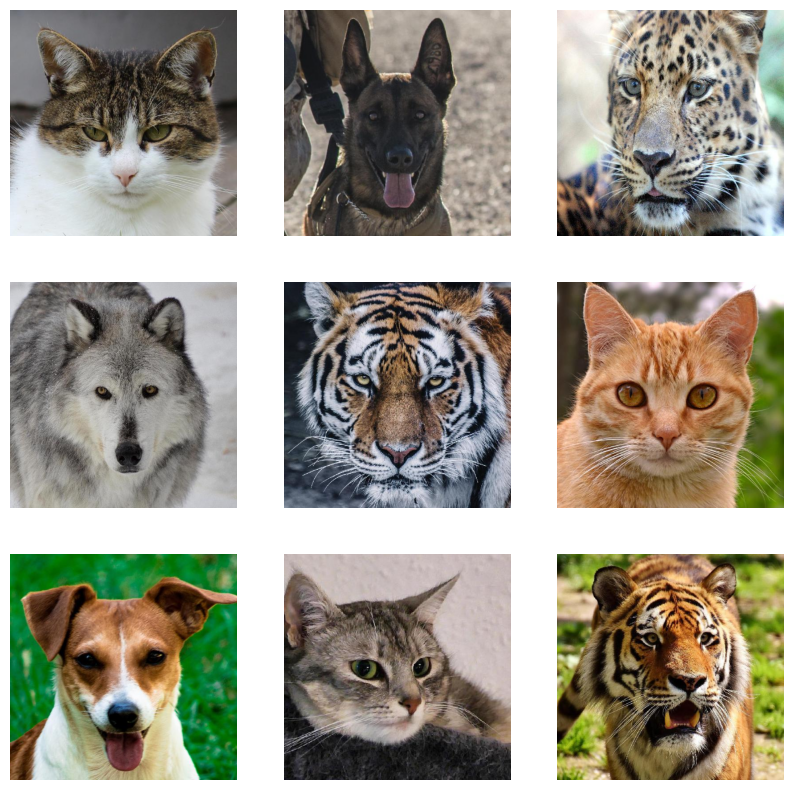

In [11]:
#Visualization
n_rows = n_cols = 3
fig,axes = plt.subplots(n_rows,n_cols,figsize=(10,10))
for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)['ImagePath'].iloc[0]).convert('RGB')
    axes[row,col].imshow(image)
    axes[row,col].axis('off')

plt.show()

In [12]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [13]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [19]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.Conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1)
    self.Conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
    self.Conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1)

    self.pool = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()#Activation function

    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16),128)
    self.output = nn.Linear(128,len(data_df["Labels"].unique()))

  def forward(self,x):
    x = self.Conv1(x)#-> (32,128,128)
    x = self.pool(x) #->(32,64,64)
    x = self.relu(x)

    x = self.Conv2(x) #-> (64,64,64)
    x = self.pool(x) #-> (64,32,32)
    x = self.relu(x)

    x = self.Conv3(x)#-> (128,32,32)
    x = self.pool(x) #-> (128,16,16)
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)

    return x

In [20]:
model = Net().to(device)

In [21]:
from torchsummary import summary
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [23]:
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer